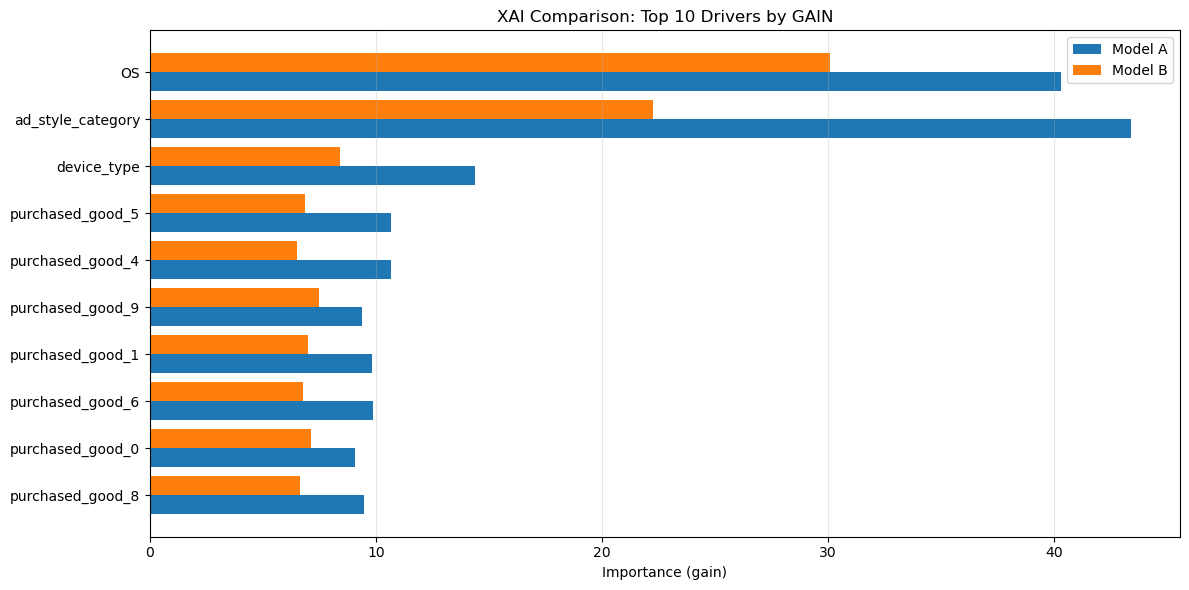

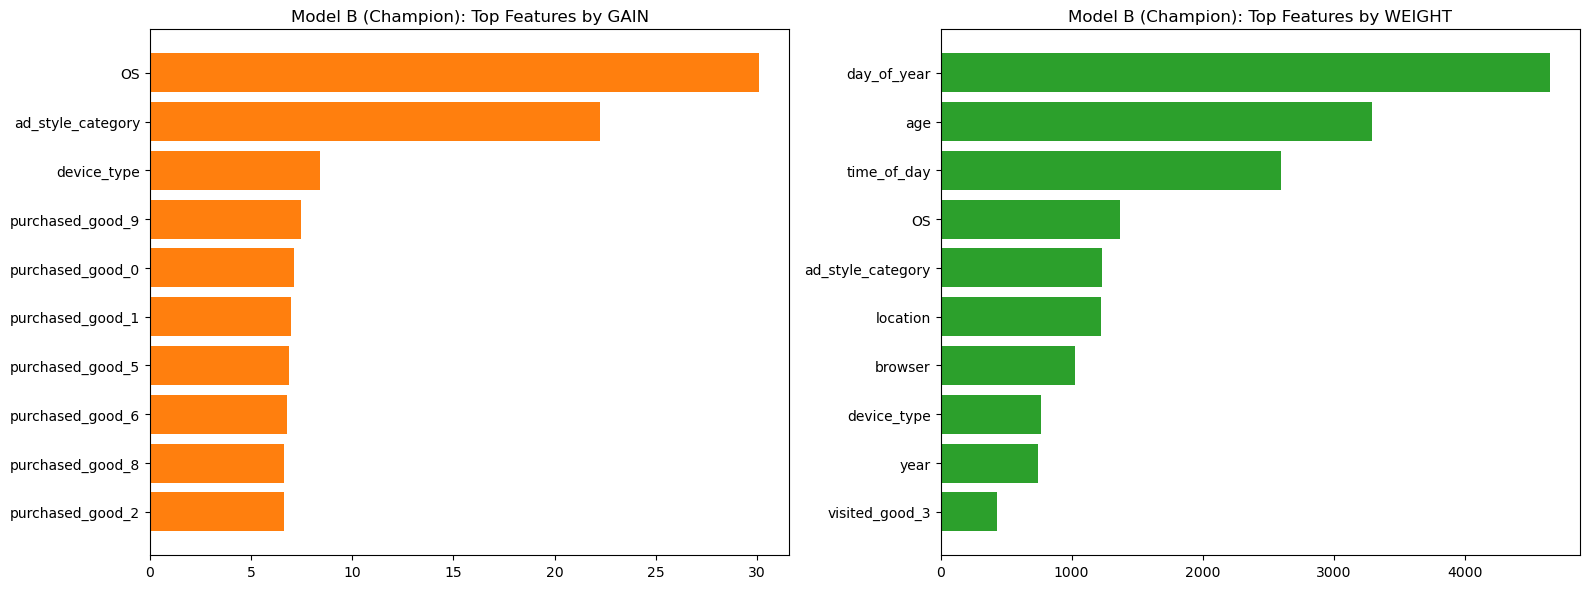

XAI SUMMARY:
1. Feature Names Restored: 'f-indexes' mapped back to human-readable names.
2. ID Column Suppressed: Visuals focus only on behavioral drivers.
3. Top Driver for Model B: OS (Gain: 30.10)


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1. Configuration & Data Loading
# -------------------------------------------------------------------
CSV_PATH = 'click_prediction.csv'
MODEL_A_PATH = 'add_model_A.json'
MODEL_B_PATH = 'add_model_B.json'

# The exact 32 features used during training
FEATURE_COLS = [
    "id", "year", "day_of_year", "time_of_day", "device_type", "location",
    "age", "browser", "OS", "ad_style_category",
    "part_of_add_evaluation_focus_group", "provided_feedback_about_add",
    "visited_good_0", "visited_good_1", "visited_good_2", "visited_good_3",
    "visited_good_4", "visited_good_5", "visited_good_6", "visited_good_7",
    "visited_good_8", "visited_good_9", "purchased_good_0", "purchased_good_1",
    "purchased_good_2", "purchased_good_3", "purchased_good_4", "purchased_good_5",
    "purchased_good_6", "purchased_good_7", "purchased_good_8", "purchased_good_9"
]

# Load Boosters
model_a = xgb.Booster()
model_a.load_model(MODEL_A_PATH)
model_b = xgb.Booster()
model_b.load_model(MODEL_B_PATH)

# FIX: Manually map feature names to avoid the 'f0, f1...' issue
model_a.feature_names = FEATURE_COLS
model_b.feature_names = FEATURE_COLS

# -------------------------------------------------------------------
# 2. Helper: Extraction & Cleaning
# -------------------------------------------------------------------


def get_importance_df(model, importance_type='gain'):
    """Extracts importance, maps names, and filters out 'id' for XAI."""
    score = model.get_score(importance_type=importance_type)
    df = pd.DataFrame(list(score.items()), columns=[
                      'feature', importance_type])

    # Filter out 'id' as it is a unique identifier, not a behavior
    df = df[df['feature'] != 'id']

    return df.sort_values(by=importance_type, ascending=False).reset_index(drop=True)

# -------------------------------------------------------------------
# 3. Visualization: Gain Comparison (Model A vs Model B)
# -------------------------------------------------------------------


def plot_comparison(imp_a, imp_b, metric='gain'):
    merged = pd.merge(imp_a, imp_b, on='feature', suffixes=('_A', '_B'))
    merged['total'] = merged[f'{metric}_A'] + merged[f'{metric}_B']
    top_10 = merged.sort_values('total', ascending=False).head(10).iloc[::-1]

    y = np.arange(len(top_10))
    plt.figure(figsize=(12, 6))
    plt.barh(y - 0.2, top_10[f'{metric}_A'], 0.4,
             label='Model A', color='tab:blue')
    plt.barh(y + 0.2, top_10[f'{metric}_B'], 0.4,
             label='Model B', color='tab:orange')

    plt.yticks(y, top_10['feature'])
    plt.title(f"XAI Comparison: Top 10 Drivers by {metric.upper()}")
    plt.xlabel(f"Importance ({metric})")
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------
# 4. Visualization: Gain vs. Weight (The "Quality Check" Plot)
# -------------------------------------------------------------------


def plot_quality_check(model_name, imp_gain, imp_weight):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Gain: How much it contributes to accuracy
    tg = imp_gain.head(10).iloc[::-1]
    ax1.barh(tg['feature'], tg['gain'], color='tab:orange')
    ax1.set_title(f"{model_name}: Top Features by GAIN")

    # Weight: How often it is used
    tw = imp_weight.head(10).iloc[::-1]
    ax2.barh(tw['feature'], tw['weight'], color='tab:green')
    ax2.set_title(f"{model_name}: Top Features by WEIGHT")

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------
# 5. Execution & Insights
# -------------------------------------------------------------------


# Calculate metrics
gain_a = get_importance_df(model_a, 'gain')
gain_b = get_importance_df(model_b, 'gain')
weight_b = get_importance_df(model_b, 'weight')

# Plot 1: The Model Comparison (Gain)
plot_comparison(gain_a, gain_b, 'gain')

# Plot 2: The Deep Dive for Champion Model (Model B)
plot_quality_check("Model B (Champion)", gain_b, weight_b)

print("XAI SUMMARY:")
print(f"1. Feature Names Restored: 'f-indexes' mapped back to human-readable names.")
print(f"2. ID Column Suppressed: Visuals focus only on behavioral drivers.")
print(
    f"3. Top Driver for Model B: {gain_b.iloc[0]['feature']} (Gain: {gain_b.iloc[0]['gain']:.2f})")
